# AX12-A Quadruped
## Gait

#### Kevin Walchko

30 April 2018

---

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

---

**Still in development**

The gait is designed for a 4 legged robot. Each leg is identical with 4 joints: coxa, femur, tibia, and tarsus. These joints are common to spiders. The kinematics are designed to follow the [modified DH process](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters#Modified_DH_parameters).

# Anatomy

<img src="quad-4-links.png" width="400px">

![](leg.jpg)

- **Coxa:** hip segment which moves left/right in red
- **Femur:** blue segment
- **Tibia:** yellow segment
- **Tarsus:** green segment


# Definitions

- **[Gait](https://en.wikipedia.org/wiki/Gait)** is the pattern of movement of the limbs of animals, including humans, during locomotion over a solid substrate. Most animals use a variety of gaits, selecting gait based on speed, terrain, the need to maneuver, and energetic efficiency. Different animal species may use different gaits due to differences in anatomy that prevent use of certain gaits, or simply due to evolved innate preferences as a result of habitat differences. 
- **Duty Factor:** Duty factor is simply the percent of the total cycle which a given foot is on the ground. Duty factors over 50% are considered a "walk", while those less than 50% are considered a run.
- **Forelimb-hindlimb Phase ($\phi$):** is the temporal relationship between the limb pairs and is often just refered to as *phase*.
- **Ripple Gait:** when one leg is in the air while the other three are holding up the body. This tends to be a stable gait when you keep the center of mass (CM) inside the triangle formed by the three legs in contact with the ground. Becuase of the stability, you could interrupt this gait at any time (i.e., stop it) and the robot will not fall over.
- **Trott Gait:** A fast gait where two legs are in the air moving while the other two legs are in contact with the ground. This is an unstable gait and the robot could fall over if the gait is not executed quickly enough.
-  **Servo space:** the angles the servos actually can move, for AX-12A, that is 0-300 degrees.
- **DH space:** This is the angle space the forward/inverse kinematics were derived in


# Rererences

- TBD

## Setup

In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function
from __future__ import division

# math
import numpy as np
from math import cos, sin, pi, atan2, sqrt, acos

# plotting and animaiton
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib import rc

# HTML/web
from IPython.lib.display import YouTubeVideo, VimeoVideo, FileLink
from IPython.display import HTML

In [2]:
# walking/gait
# goto the library folder and install with: pip install -e .
from quadruped import DiscreteRippleGait
from quadruped import Leg4

# Other Robots

Here are some interesting walking robots from around the web.

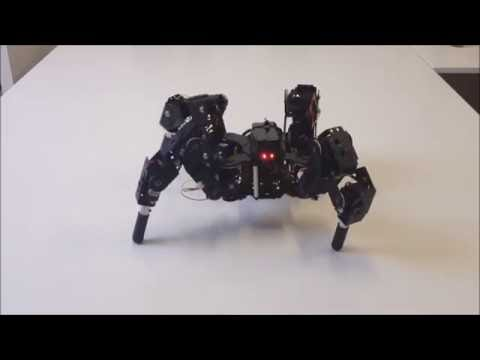

In [4]:
# 4 servos per leg
YouTubeVideo('RgV6BoCdTcc', width="100%")

In [5]:
# this is the XL-320 version and it has 3 servos per leg
VimeoVideo('194676675', width="100%")

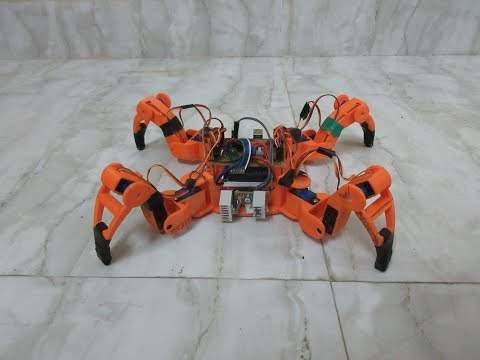

In [6]:
# these are toy RC servos, 3 servos per leg
YouTubeVideo('HBlfdYWyj90', width="100%")

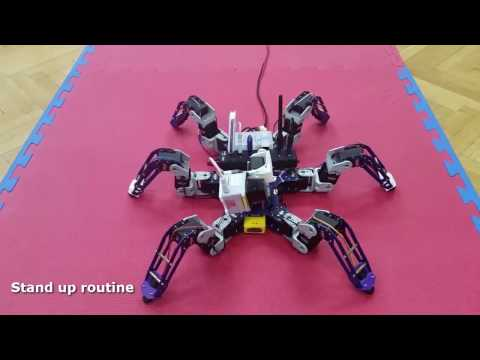

In [7]:
# is actually a hexapod, AX-12 servos, 6 legs, 3 servos per leg
YouTubeVideo('DQkKJwV0ae4', width="100%")

# Walking

| Variable            | Definition |
|:--------------------|:-------------------------------------|
|k                    |step                                  |
|i                    |leg                                   |
|$p_i$                |x,y,z position of leg                 |
|$\phi_{i,k}$         |foot position for leg i at step k     |
|$z_i$                |height modifier of leg i              |
|$R_z$                |rotation matrix around z axis         |

Gaits for robots are based on those of animals. There is a rhythmic repetitive pattern
that they use and we will use that to get our robot to move. The walking patter shown below
has 12 steps, but it could have any number. The table shows for each step in the cycle,
where each leg is (phase) and how high (h) it is lifted off the ground in the $z$ axis
direction.

|            k    | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10| 11|
|-----------------|---|---|---|---|---|---|---|---|---|---|---|---|
|$\phi_{1,k}$     |9/9|6/9|3/9|0/9|1/9|2/9|3/9|4/9|5/9|6/9|7/9|8/9|
|$z_1$            |h/2| h |h/2| 0 |0  |0  |0  |0  |0  |0  |0  |0  |

Each leg executes this pattern in the order of: 0,3,1,2. This leads to a stable
tripod gait. Each leg is at a different point in the gait table above and its offset
is shown below:

|leg   | 0 | 1 | 2 | 3 |
|------|---|---|---|---|
|offset| 0 | 6 | 3 | 9 |

Thus at step 0, Leg 0 is at the beginning (k=0) while Leg 1 is at k=6.

## Calculating Foot Position

The quadruped's linear and rotational movements are decoupled. The equation below
shows how the y axis movement is calculated, but the x axis equation is the same.
Basically, the $\Delta$ is the delta change in leg position from the normal
or resting leg position.

$$
\delta(x,y) = linear(x,y) + rotational(x,y) \\
\Delta_{i,k} = \delta(x,y)/2 - \phi_{i,k} \delta(x,y)
$$

where the i identifies the leg ($i \in [0,1,2,3]$), k is the
step ($k \in [0,1, \ldots 11]$) and linear/rotation are the commanded
linear or rotation movements of the robot.

Now each leg exists in its own leg reference frame and they are all the same ... symetry.
Thus, the foot placement is only calculated for one foot and then that answer rotated 
and translated for the remaining three feet. Each leg frame is rotated 45 degrees around
the robot's center. The adjustment for each leg frame is:

|Leg| 0 | 1 | 2 | 3 |
|---|---|---|---|---|
|Rotation (rads)|-$\pi$/2| $\pi$/2|3$\pi$/4|-3$\pi$/4|


The rotation part is handled by taking the neutral leg position (x,y,z), rotating it about
the z axis and calculating the delta difference by subtracting off the original
position.

$$
R_z (\theta)=
\begin{bmatrix}
    \cos(\theta) & -\sin(\theta) & 0 \\
    \sin(\theta) & \cos(\theta) & 0 \\
    0 & 0 & 1
\end{bmatrix} \\
rotational(x,y) = R_z(\theta) p_i - p_i
$$

Finally, the new leg position is:

$$
p_i' = p_i + \Delta_{i,k}
$$

## Servos

There are 2 key configurations: stow and stand. Stow is when the robot is all packed up like a dead spider and stand are the neutral leg positions where the robot is naturally standing still.

<table>
<tr>
<td> <img src="stow.jpg" style="width:95%;"/> </td>
<td> <img src="stand.jpg" style="width:95%;"/> </td>
</tr>
</table>

![](ax-12-quad-servos.png)

Each leg is composed of 4 servos, with Leg 0 (servo 1, servo 2, servo 3, servo 4) being the right front leg. The remaining 3 legs are numbered counter clockwise from 0 with the servo numbers increasing with each leg. The servo numbers are also the servo ID numbers when commanding them.

The servos are able to move between 0-300 degrees. In servo space, with the leg laid out straight (or as straight as posible given its construction), there are offsets between servo space (what the servos can actually do) and DH space (how the forward/reverse kinematics were derived).

![](real-leg.jpg)

![](leg-coordinate-system.png)

For example, in DH space, the straight leg would have all servos commanded to angle 0, but as seen in the pictures and the table below, there are offsets.

| Leg Orientation | 1 | 2 | 3 | 4 |
|-----------------|---|---|---|---|
| Straight        |150|123|194|167|
| Stand           |150|160|130|100|
| Stow            |150|250| 80| 60|


# Gait Analysis

Let's take a look at how the robot moves around. In each case, the robot is commanded to move in a linear 2D (x,y) direction *and* an angular rotation about the z-axis. The input command is: `[x, y, rotz]`.  

In [28]:
from math import cos, sin, sqrt, pi


def rot_z_tuple(t, c):
	"""
	t - theta [radians]
	c - [x,y,z]
	return - (x,y,z) tuple rotated about z-axis
	"""
	ans = (
		c[0]*cos(t)-c[1]*sin(t),
		c[0]*sin(t)+c[1]*cos(t),
		c[2]
	)

	return ans


# make a static method in Gait? Nothing else uses it
def rot_z(t, c):
	"""
	t - theta [radians]
	c - [x,y,z]
	return - [x,y,z] numpy array rotated about z-axis
	"""
	ans = [
		c[0]*cos(t)-c[1]*sin(t),
		c[0]*sin(t)+c[1]*cos(t),
		c[2]
	]

	return ans


class kGait(object):
	"""
	Base class for gaits. Gait only plan all foot locations for 1 complete cycle
	of the gait.

	Like to add center of mass (CM) compensation, so we know the CM is always
	inside the stability triangle.

	Gait knows:
	- how many legs
	- leg stride (neutral position)
	"""
	# these are the offsets of each leg
	legOffset = [0, 6, 3, 9]
	# frame rotations for each leg
	# cmrot = [pi/4, -pi/4, -3*pi/4, 3*pi/4]
	# frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]  # this seem to work better ... wtf?
	frame = [pi/4, -pi/4, -3*pi/4, 3*pi/4]
	moveFoot = None
	rest = None
	scale = 50.0

	def __init__(self, rest):
		# the resting or idle position/orientation of a leg
		self.rest = rest

	def command(self, cmd):
		"""
		Send a command to the quadruped
		cmd: [x, y, rotation about z-axis], the x,y is a unit vector and
		rotation is in radians
		"""
		x, y, rz = cmd
		d = sqrt(x**2+y**2)

		# handle no movement command ... do else where?
		if d <= 0.1 and abs(rz) < 0.1:
			x = y = 0.0
			rz = 0.0
			return None
		# commands should be unit length, oneCyle scales it
		elif 0.1 < d:
			x /= d
			y /= d
		else:
			return None

		angle_limit = pi/2
		if rz > angle_limit:
			rz = angle_limit
		elif rz < -angle_limit:
			rz = -angle_limit

		return self.oneCycle_alt(x, y, rz)

	def oneCycle_alt(slef, x, y, rz):
		raise Exception('*** Gait: wrong function, this is base class! ***')


class kDiscreteRippleGait(kGait):
	"""
	Discrete 12 step gait
	"""
	steps = 0

	def __init__(self, height, rest):
		"""
		height: added to z
		rest: the neutral foot position
		"""
		kGait.__init__(self, rest)
		# self.phi = [9/9, 6/9, 3/9, 0/9, 1/9, 2/9, 3/9, 4/9, 5/9, 6/9, 7/9, 8/9]  # foot pos in gait sequence
		self.phi = [6/8, 4/8, 2/8, 0/8, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 8/8]
		# maxl = h  # lifting higher gives me errors
		# minl = maxl/2
		# self.z = [minl, maxl, minl, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # leg height
		self.setLegLift(height)
		self.steps = len(self.phi)

	def setLegLift(self, height):
		maxl = height  # lifting higher gives me errors
		minl = maxl/2
		self.z = [minl, maxl, minl, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]  # leg height

	def eachLeg(self, index, cmd):
		"""
		interpolates the foot position of each leg
		cmd:
			linear (mm)
			angle (rads)
		"""
		rest = self.rest
		i = index
		phi = self.phi[i]
		xx, yy, rzz = cmd

		# rotational commands -----------------------------------------------
		angle = rzz/2-rzz*phi
		rest_rot = rot_z(-angle, rest)

		# create new move command
		move = [
			xx/2 - phi*xx,
			yy/2 - phi*yy,
			self.z[i]
		]

		# new foot position: newpos = rot + move ----------------------------
		# newpos = move + rest_rot
		newpos = [0]*3
		newpos[0] = move[0] + rest_rot[0]
		newpos[1] = move[1] + rest_rot[1]
		newpos[2] = move[2] + rest_rot[2]

		# print('New  [](x,y,z): {:.2f}\t{:.2f}\t{:.2f}'.format(newpos[0], newpos[1], newpos[2]))
		return newpos

	def oneCycle_alt(self, x, y, rz):
		"""
		direction of travel x, y (2D plane) or rotation about z-axis
		Returns 1 complete cycle of where do the feet go for all 4 legs.
		"""

		# check if x, y, rz is same as last time commanded, if so, return
		# the last cycle response, else, calculate a new response
		# ???

		scale = self.scale
		cmd = (scale*x, scale*y, rz)
		ret = {
			0: [],
			1: [],
			2: [],
			3: []
		}  # 4 leg foot positions for the entire 12 count cycle is returned

		for i in range(0, self.steps):  # iteration, there are 12 steps in gait cycle
			for legNum in [0, 1, 2, 3]:  # order them diagonally
				rcmd = rot_z_tuple(self.frame[legNum], cmd)
				index = (i + self.legOffset[legNum]) % self.steps
				pos = self.eachLeg(index, rcmd)  # move each leg appropriately
				# print('Foot[{}]: {:.2f} {:.2f} {:.2f}'.format(legNum, *(pos)))
				ret[legNum].append(pos)

		return ret


In [58]:
# using gait, lets create the leg angles
# gait: cmd -> feet position for each step
# leg: feet pos -> servo angles for each step
# rplot -> plots each of those servo angles

def walk(cmd):
    data = {
        # [ length, (limits), offset]
        'coxa':   [52, [-90, 90],   150],
        'femur':  [90, [-100, 100], 123],   # fixme
        'tibia':  [89, [-90, 120],  194],  # fixme
        'tarsus': [90, [-90, 90],   167],

        # gait
        # Angles: 0.00 75.60 -120.39 -45.22
        # 0.00 93.51 -138.68 -44.83
        'stand': [0, 94, -139, -45],  # this determines the neutral leg position
        # 'sit': [0, 90, -90, -90],

        # engine
        # 'serialPort': '/dev/tty.usbserial-A506BOT5'
    }

    leg = Leg4(data)  # 4 servo leg
    gait = kDiscreteRippleGait(
        35.0,  # how high the leg is lifted
        leg.getNeutralPos()  # neutral x,y,z position
    )
#     gait.phi = [9/9, 6/9, 3/9, 1/9, 2/9, 3/9, 4/9, 5/9, 6/9, 7/9, 8/9, 9/9]
    gait.phi = [6/8, 4/8, 2/8, 0/8, 1/8, 2/8, 3/8, 4/8, 5/8, 6/8, 7/8, 8/8]
    #            up,  up,  up, dwn, dwn, dwn, dwn, dwn, dwn, dwn, dwn, dwn]
#     gait.scale = 100
    pts = gait.oneCycle_alt(*cmd)                         # array of 3d foot pts
    angle = leg.generateServoAngles(pts)              # array of leg servo angles
    print('Neutral pos:', leg.getNeutralPos())
    return pts, angle

## Straight

![](walking.png)

First let's calculate the robot's foot position and servo angles. Each leg is identical, so we will only generate the movement for 1 leg and then do a rotation/translation to re-orient the desired foot placement for the remaining 3 legs.

Looking at the diagram above, when the robot is moving "straight" in the body frame, it is actually moving in a diagonal as observed in the leg frame. Thus, when calculating foot positions for each step, we expect to see that diagonal movement.

In [59]:
pts, angle = walk([1,0,0])  # x, y, rotation-z

{'stand': [150, 217, 55, 122], 'sit': None, 'neutral': (108.65442088863145, 0.0, -63.15173900221855)}
Neutral pos: (108.65442088863145, 0.0, -63.15173900221855)


Let's first plot the feet positions in the body frame and see if we are moving straight.

47.5 67.5


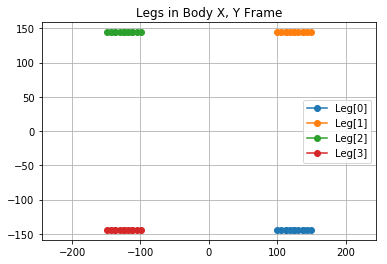

In [60]:
def plot_body_frame(pts):
    def rot_z(t, c):
        """
        t - theta [radians]
        c - [x,y,z]
        return - [x,y,z] numpy array rotated about z-axis
        """
        ans = [
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ]

        return ans

    # plot things in global body frame
#     body = [(100,-100), (100,100),(-100,100),(-100,-100)] # CCW
#     frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    dy = 135/2
    dx = 95/2
    print(dx,dy)
    body = [(dx,-dy), (dx,dy),(-dx,dy),(-dx,-dy)] # CCW
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    for ll in range(4):
        aa = frame[ll]
        pp = [rot_z(aa, p) for p in pts[ll]]
        xx = [v[0]+body[ll][0] for v in pp]
        yy = [v[1]+body[ll][1] for v in pp]
        plt.title('Legs in Body X, Y Frame'.format(ll))
        plt.plot(xx,yy, label='Leg[{}]'.format(ll), marker='o')
        plt.grid(True)
        plt.axis('equal')
    plt.legend();
    
plot_body_frame(pts)

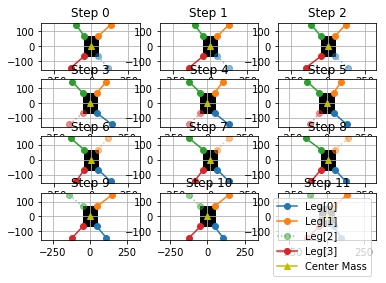

In [61]:
def plot_body_frame2(pts):
    def rot_z(t, c):
        """
        t - theta [radians]
        c - [x,y,z]
        return - [x,y,z] numpy array rotated about z-axis
        """
        ans = [
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ]

        return ans

#     import pylab
#     pylab.rcParams['figure.figsize'] = (15.0, 15.0)
    
    # plot things in global body frame
    dy = 135/2
    dx = 95/2
    body = [(dx,-dy), (dx,dy),(-dx,dy),(-dx,-dy)] # CCW
#     frame = [pi/4, -pi/4, -3*pi/4, 3*pi/4]
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    feet = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for leg in range(4):
        for pos in pts[leg]:
            rpt = rot_z(frame[leg], pos)
            feet[leg].append((body[leg][0] + rpt[0], body[leg][1] + rpt[1], rpt[2]))
    
    for step in range(len(feet[0])):
        ax = plt.subplot(4,3,step+1)
        cm = []
        for leg in range(4):
            # draw the feet that are on the ground
            if feet[leg][step][2] < -62:
                plt.plot(
                    [body[leg][0],feet[leg][step][0]],
                    [body[leg][1],feet[leg][step][1]], 
                    label='Leg[{}]'.format(leg),
                    marker='o'
                )
                cm.append(feet[leg][step])  # save to calculat cm position
            else:
                plt.plot(
                    [body[leg][0],feet[leg][step][0]],
                    [body[leg][1],feet[leg][step][1]], 
                    label='Leg[{}]'.format(leg),
                    marker='o',
                    linestyle=':',
                    alpha=0.5
                )
#         x = 0
#         y = 0
#         for p in cm:
#             x += p[0]
#             y += p[1]
#         x /= len(cm)
#         y /= len(cm)
#         plt.plot([x],[y],color='y', marker='^')  # center mass
        plt.plot([0],[0],color='y', marker='^', label='Center Mass')  # center mass
        
        plt.title('Step {}'.format(step))
        plt.grid(True)
#         plt.plot([x[0] for x in body], [y[1] for y in body], label='Body', marker='o')
        rect = plt.Rectangle(
            body[3],  # lower left corner
            body[1][0] - body[2][0],  # width
            body[1][1] - body[0][1],  # height
            color='k')
        ax.add_patch(rect)
#         ax.axis([-200,200,-200,200])
        ax.axis('equal')
            
    plt.legend();
    
plot_body_frame2(pts)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


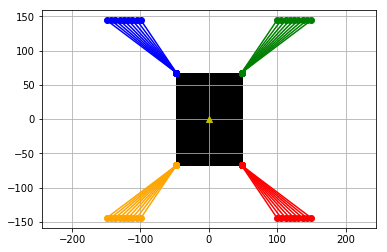

In [62]:
def plot_body_frame3(pts):
    def rot_z(t, c):
        """
        t - theta [radians]
        c - [x,y,z]
        return - [x,y,z] numpy array rotated about z-axis
        """
        ans = [
            c[0]*cos(t)-c[1]*sin(t),
            c[0]*sin(t)+c[1]*cos(t),
            c[2]
        ]

        return ans

#     import pylab
#     pylab.rcParams['figure.figsize'] = (8.0, 8.0)
    
    # plot things in global body frame
#     body = [(100,-100), (100,100),(-100,100),(-100,-100)] # CCW
    dy = 135/2
    dx = 95/2
    body = [(dx,-dy), (dx,dy),(-dx,dy),(-dx,-dy)] # CCW
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    feet = {
        0: [],
        1: [],
        2: [],
        3: []
    }
    
    for leg in range(4):
        for pos in pts[leg]:
            rpt = rot_z(frame[leg], pos)
            feet[leg].append((body[leg][0] + rpt[0], body[leg][1] + rpt[1], rpt[2]))
    
    colors = ['r', 'g', 'b', 'orange']
    for step in range(len(feet[0])):
        ax = plt.subplot(1,1,1)
        cm = []
        for leg in range(4):
            # draw the feet that are on the ground
            if feet[leg][step][2] < -62:
                plt.plot(
                    [body[leg][0],feet[leg][step][0]],
                    [body[leg][1],feet[leg][step][1]], 
                    label='Leg[{}]'.format(leg),
                    marker='o',
                    color=colors[leg]
                )
                cm.append(feet[leg][step])  # save to calculat cm position
            else:  # draw the moving foot different
                plt.plot(
                    [body[leg][0],feet[leg][step][0]],
                    [body[leg][1],feet[leg][step][1]], 
                    label='Leg[{}]'.format(leg),
                    marker='o',
                    linestyle=':',
                    alpha=0.5,
                    color=colors[leg]
                )
#         x = 0
#         y = 0
#         for p in cm:
#             x += p[0]
#             y += p[1]
#         x /= len(cm)
#         y /= len(cm)
#         plt.plot([x],[y],color='y', marker='^')  # center mass
    plt.plot([0],[0], color='y', marker='^', label='Center Mass')  # center mass
    plt.grid(True)
#         plt.plot([x[0] for x in body], [y[1] for y in body], label='Body', marker='o')
    rect = plt.Rectangle(
        body[3],  # lower left corner
        body[1][0] - body[2][0],  # width
        body[1][1] - body[0][1],  # height
        color='k')
    ax.add_patch(rect)
    ax.axis('equal')
            
#     plt.legend();
    
plot_body_frame3(pts)

### Sequence

The robot lifts its legs in an ordered sequence. Looking at the state diagram and the graph below, the order is 0, 3, 1, 2.

![](quad-sequence.png)

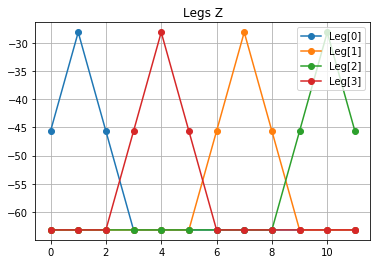

In [63]:
# order of lift is: 0, 3, 1, 2, repeat
for ll in range(4):
    ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
    zz = [v[2] for v in pts[ll]]
    plt.title('Legs Z'.format(ll))
    plt.plot(zz, label='Leg[{}]'.format(ll), marker='o')
    plt.grid(True)
plt.legend();

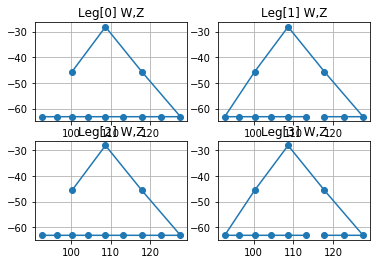

In [64]:
def plot_feet(pts):
    for ll in range(4):
        ww = [sqrt(v[0]**2 + v[1]**2) for v in pts[ll]]
        zz = [v[2] for v in pts[ll]]
        plt.subplot(2,2,ll+1)
        plt.plot(ww,zz, marker='o')
        plt.title('Leg[{}] W,Z'.format(ll))
        plt.grid()
        
plot_feet(pts)

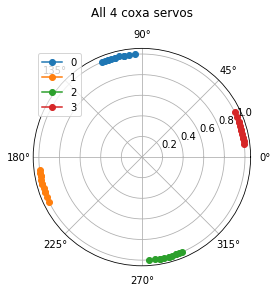

In [65]:
def plot_coxa(angle):
    frame = [-pi/4, pi/4, 3*pi/4, -3*pi/4]
    ax = plt.subplot(111, projection='polar')
    for ll in range(4):
        tt = [(v[0]*pi/180)+frame[ll] for v in angle[ll]]
        rr = [1]*len(tt)
        ax.plot(tt, rr, label=str(ll), marker='o')
    ax.legend()
    ax.set_title('All 4 coxa servos\n');

plot_coxa(angle)

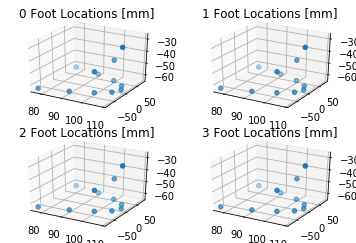

In [57]:
def plot_feet_3d(pts):
    fig = plt.figure()
    for ll in range(4):
        ax = fig.add_subplot(2,2,ll+1, projection='3d')
        xx = [v[0] for v in pts[ll]]
        yy = [v[1] for v in pts[ll]]
        zz = [v[2] for v in pts[ll]]
        ax.scatter(xx,yy,zz)
        ax.set_title('{} Foot Locations [mm]'.format(ll));

plot_feet_3d(pts)

In [42]:
class LegVis(object):
    def __init__(self, angle, legNum=0):
        # when i call the animation, this will make it work
        rc('animation', html='html5')

        # for some stupid reason, matplotlib/jupyter plots the thing twice
        # this shuts it off until we are ready to turn back on inline plotting
        %matplotlib agg
        %matplotlib agg
        
        self.angle = angle
        self.legNum = legNum

        fig = plt.figure()
        self.fig = fig
        
        # radial plot 
        self.ax1 = fig.add_subplot(121,projection='polar')
        self.ax1.set_title('Azimuth Angle (x-y plane)\n')
        # line1, = ax1.plot([], [], lw=2)
        self.line1 = Line2D([], [], color='black')
        self.ax1.add_line(self.line1)
        # ax1.set_aspect('equal', 'datalim')

        # scatter plot
        self.ax2 = fig.add_subplot(122, aspect='equal')
        # line2, = ax2.plot([], [], lw=2)
        self.line2 = Line2D([], [], color='black', linewidth=2)
        self.ax2.set_xlabel('w')
        self.ax2.set_ylabel('z')
        self.ax2.add_line(self.line2)
        self.ax2.set_xlim(-10, 300)
        self.ax2.set_ylim(-100, 150)
        # ax2.set_aspect('equal')
        self.ax2.grid()  # turn grid on
        self.ax2.set_title('Leg {}'.format(self.legNum))
        
    def rplot(self, t1, t2, t3, t4, degrees=True):
        """Given the 4 joint angles (in rads), plot the arm in the x-y and w-z planes

        x = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*cos(t1)
        y = (d2 + l1*cos(t2) + l2*cos(t2 + t3) + l3*cos(t2 + t3 + t4))*sin(t1)
        z = l1*sin(t2) + l2*sin(t2 + t3) + l3*sin(t2 + t3 + t4)
        """
        l1 = 52
        l2 = 89
        l3 = 90
        l4 = 95

        ptsx = [0]
        ptsy = [0]

        if degrees:
            t1 *= pi/180
            t2 *= pi/180
            t3 *= pi/180
            t4 *= pi/180


        # our definition is reverse or these joints
        # link 1
        x0 = l1
        y0 = 0
        ptsx.append(x0)
        ptsy.append(y0)

        # link 2
        x1 = x0 + l2*cos(t2)
        y1 = y0 + l2*sin(t2)
        ptsx.append(x1)
        ptsy.append(y1)

        # link 3
        x2 = x1 + l3*cos(t2 + t3)
        y2 = y1 + l3*sin(t2 + t3)
        ptsx.append(x2)
        ptsy.append(y2)

        # link 4
        x3 = x2 + l4*cos(t2 + t3 + t4)
        y3 = y2 + l4*sin(t2 + t3 + t4)
        ptsx.append(x3)
        ptsy.append(y3)

        self.line1.set_data([0, t1], [0, 1.0])
        self.line2.set_data(ptsx, ptsy)
        return (self.line1, self.line2)
    
    def anim_animate(self, i):
        angles = self.angle[self.legNum][i]
        # put back into DH space, note, the offsets aren't all the same
        aa = [a-o for a,o in zip(angles, [150,150,220,150])]
        return self.rplot(*aa)
    
    def run(self):
        %matplotlib inline
        return animation.FuncAnimation(self.fig, self.anim_animate, frames=len(self.angle[self.legNum]), blit=True)

In [43]:
# rc('animation', html='html5')
s = LegVis(angle)
anim = s.run()
anim
# HTML(anim.to_html5_video())

In [ ]:
anim.save('walk-straight.mp4')

In [ ]:
# from IPython.lib.display import FileLink
# FileLink('./walk-straight.mp4')

# Turn

In [44]:
pts, angle = walk([0,0,pi/2])

{'stand': [150, 217, 55, 122], 'sit': None, 'neutral': (108.65442088863145, 0.0, -63.15173900221855)}
Neutral pos: (108.65442088863145, 0.0, -63.15173900221855)


47.5 67.5


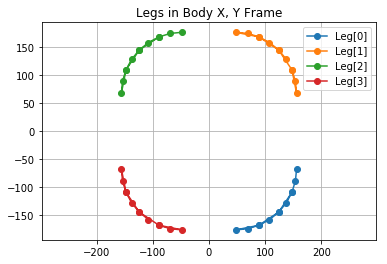

In [45]:
plot_body_frame(pts)

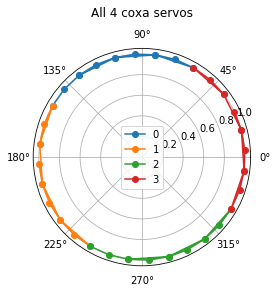

In [46]:
plot_coxa(angle)

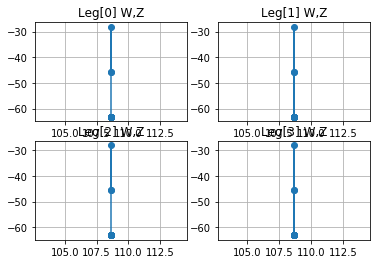

In [47]:
plot_feet(pts)

/usr/local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


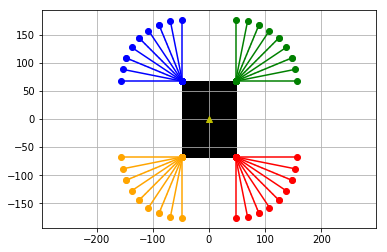

In [48]:
plot_body_frame3(pts)

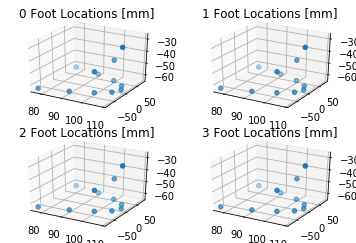

In [49]:
plot_feet_3d(pts)

In [50]:
s = LegVis(angle)
anim = s.run()
anim

In [ ]:
anim.save('walk-turn.mp4')

# Diagonal

Now this time we are walking at a diagonal. Notice because of the diagonal direction, 2 of the legs coxa servos do not move, they only the move (kind of like reach) in the W-Z frame.

In [51]:
pts, angle = walk([1,1,0])

{'stand': [150, 217, 55, 122], 'sit': None, 'neutral': (108.65442088863145, 0.0, -63.15173900221855)}


Exception: 1 angle out of range DH: -198.5   Servo: -75.5 deg

In [ ]:
plot_body_frame(pts)

In [ ]:
plot_coxa(angle)

In [ ]:
plot_feet(pts)

In [ ]:
plot_feet_3d(pts)

In [ ]:
plot_body_frame3(pts)

In [ ]:
# leg 0 is in the direction of travel and doesn't swing (see coxa angles above)
s0 = LegVis(angle,0)
anim = s0.run()
anim

In [ ]:
anim.save('walk-diagonal-0.mp4')

In [ ]:
s1 = LegVis(angle, 1)
anim = s1.run()
anim

In [ ]:
anim.save('walk-diagonal-1.mp4')

# Stability

![](cm-shift.png)

When walking, this gate has 3 feet down at all times and one foot moving forward. This creates a tripod (grey shaded triangle) that supports the body weight. This is generally considered a stable gait because of this, but if the robot is perfectly ballanced, the center of mass (CM) lies right on the inside edge of the tripod. When it comes to balancing, you need to keep your CM inside the triangle formed by the feet. Now, the reality is the robot is not perfectly balance so this is actually an issue which could cause the robot to fall over.

## Shifting CM

When a foot is down and planted (shown by x), those three form the stable platform to hold up the body. The moving leg (shown as an empty box) provides nothing. To keep the CM inside the triagle formed by the three feet on the ground, we are ggoing to shift the CM towards the opposite of the swinging leg.

| Foot      | 0 | 1 | 2 | 3 | Shift CM Toward Leg|
|-----------|---|---|---|---|-------|
| 0 Moving  |   | x | x | x | 2     |
| 1 Moving  | x |   | x | x | 3     |
| 2 Moving  | x | x |   | x | 0     |
| 3 Moving  | x | x | x |   | 1     |

In [ ]:
# work in progress ...

# todo

adapt the order of leg movement based on direction

